<a href="https://colab.research.google.com/github/anruki/Procesamiento_YOLO/blob/main/p3_ana_memoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PROCESAMIENTO DE VÍDEO PARA LA GANADERÍA
---
### 🤓 **Autores**: Ana Robledano y Miguel Egido
### 📸 **Asignatura**: Procesamiento Multimedia
### 🧑 **Profesor**: Daniel Eusebio
### 👀 **Algoritmo**: You Only Look Once (YOLO)

---





# 1. INTRODUCCIÓN

En este proyecto se estudian casos de uso del procesamiento de vídeo junto con inteligencia artificial en la ganadería.

Se realizan las siguientes técnicas:
* __Preprocesamiento__: manipulación de vídeo y aplicación de filtros.
* __Inteligencia Artificial__: algoritmo YOLO para la detección de animales
* __Preprocesamiento__: para extraer características de los animales detectados (su posición y velocidad).

El preprocesamiento facilita la tarea de reconocimiento de la IA y reduce la capacidad de computación necesaria para la ejecución del algoritmo YOLO.

El papel del procesamiento multimedia en este proyecto es crear un ``pipeline`` que transforma el vídeo incial y utiliza las detecciones del algoritmo YOLO para sacar características como la posición respecto a un área delimitadora.



En un primer acercamiento al problema, utilizamos el siguiente programa para detectar un caballo en movimiento.

```
# Cargar el modelo YOLOv8
model = YOLO('yolov8n.pt')

# Cargar el video
video_path = 'sunday_vid.mov'
cap = cv2.VideoCapture(video_path)

# Verificar si el video se cargó correctamente
if not cap.isOpened():
    print("Error: No se pudo abrir el video.")
    exit()
while True:
    # Leer frame
    ret, frame = cap.read()
    if not ret:
        print("Fin del video o no se puede obtener el frame.")
        break

    # Aplicar preprocesamiento
    frame_preprocessed = preprocess_frame(frame)

    # Detectar y rastrear objetos
    results = model.track(frame_preprocessed, persist=True,classes=17)

    # Dibujar los resultados en el frame original (sin preprocesar)
    frame_ = results[0].plot()  # Frame anotado

    # Mostrar el frame anotado
    cv2.imshow('YOLOv8 Tracking', frame_)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Presiona 'q' para salir
        break

# Liberar recursos
cap.release()
cv2.destroyAllWindows()
print('Procesamiento de video completo.')

```

**Explicación del código**



1.   Carga el modelo YOLOv8:
2.   Usa un modelo preentrenado (`yolov8n.pt`) para detección de objetos. Este modelo es el más rápido en ejecución pero menos preciso. Para detecciones más complejas desempeña con mejor precisión los modelos preentrenados `yolov8m.pt` (medium) y `yolov8l.pt` (large).

3. Carga el video:
    - Abre el archivo de video `sunday_vid.mov`
4. Procesa cada frame:
    - Preprocesa el frame con la función `preprocess_frame` explicada posteriormente.
    - Detecta y rastrea objetos en el frame usando el modelo.
    - Dibuja las anotaciones (cajas delimitadoras) sobre el frame.
    - Muestra el video anotado en tiempo real.
5. Finaliza liberando recursos.

**Explicación del trackeo**

Esta función realiza detección y seguimiento de objetos en un solo paso:

```
results = model.track(frame_preprocessed, persist=True, classes=17)
```



  *  `` input `` frame procesado.

  *  `` persist=True`` utiliza fotogramas anteriores para rastrear un mismo objeto que se desplaza a lo largo del video sin perder su identidad.

  *  `` classes=17`` filtra los objetos detectados para rastrear solo aquellos pertenecientes a la clase 17 (caballos).
  * ``conf`` toma valores entre 0 y 1, es el umbral de confianza mínima que debe tener una detección para ser considerada válida. Como en este caso no se especifica, se utiliza la confianza predeterminada del 25%.

  *  `` output`` objeto ``results`` que contiene información sobre las detecciones, como las coordenadas de las cajas delimitadoras, etiquetas de clases, puntuaciones de confianza, y los identificadores asignados a cada objeto rastreado.

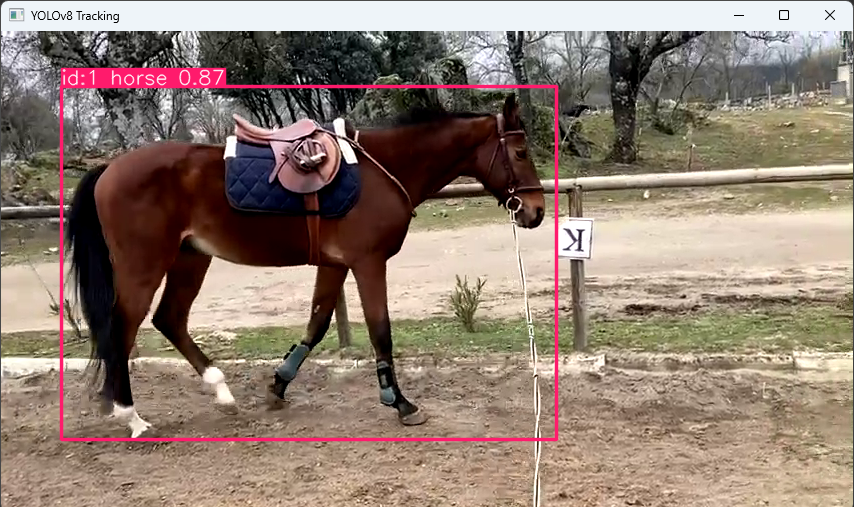

Cada objeto detectado tendrá un id único, un nombre de etiqueta y una probabilidad de pertenecer a esa clase.

# 1.1. Preprocesamiento

```
# Función para preprocesamiento del frame
def preprocess_frame(frame):
    # Aplicar desenfoque Gaussiano para reducir el ruido
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    # Aplicar operación de apertura para eliminar ruido pequeño
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    opened = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel)
    # Aplicar operación de cierre para rellenar pequeños huecos
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    return closed
```

Dependiendo del plano de la cámara y el entorno (árboles, montañas,...) será más conveniente realizar distintos filtros u operaciones morfológicas. Los modelos YOLO están optimizados para trabajar directamente con entradas RGB, por lo que cambiar a escala de grises introduce una conversión innecesaria sin mejorar el resultado.

Para comprobar la efectividad del procesamiento medimos:

**Tiempo de ejecución**

Se busca que el tiempo de ejecución sea el mínimo posible. Para que cada frame se pueda procesar en el tiempo que transcurre el vídeo y no quede ningún frame sin procesar cuando se utilice el programa en una cámara que graba en tiempo real.

```
import time
# Medir el tiempo de inicio
start_time = time.time()
```

Al inicio del programa.

```
# Medir el tiempo de finalización
end_time = time.time()
execution_time = end_time - start_time
print(f'Tiempo de ejecución: {execution_time:.2f} segundos')
```

Al final del programa.

---

**Precisión de las predicciones**

Se puede comprobar mediante un recuento de probabilidades o visualmente en el vídeo procesado. Se busca que cada animal sea detectado por su etiqueta correcta y esta aparezca en el frame.

```
    # Calcular la suma de probabilidades y contar frames
    for box in results[0].boxes:
        confidence = float(box.conf)  # Probabilidad
        confidence_sum += confidence
        frame_count += 1
```

---

Utilizando el siguiente preprocesamiento se obtiene:

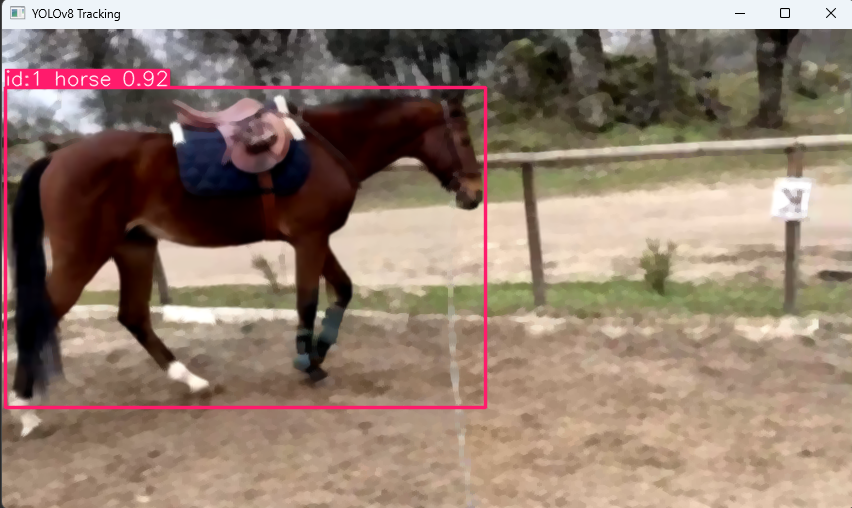

```
Probabilidad promedio final: 0.90340
Procesamiento de video completo.
Tiempo de ejecución: 26.62 segundos
```

Si no se hubiese realizado preprocesamiento:

```
Probabilidad promedio final: 0.89610
Procesamiento de video completo.
Tiempo de ejecución: 26.39 segundos
```

Es una ligera mejora de la precisión a cambio de un tiempo de ejecución un poco mayor. Dado que el algoritmo YOLO ya está optimizado para realizar operaciones internamente, comprobamos que el uso de filtros y operaciones morfológicas no son totalmente necesarias. Aunque proximamente, para vídeos de baja definición sí realizaremos un preprocesamiento adaptado.

## 1.2.Algoritmo You Only Look One (YOLO)


El algoritmo You Only Look Once (YOLO), es un sistema de código abierto para detección de objetos en tiempo real. Utiliza una única red neuronal convolucional para detectar objetos en imágenes.

Para su funcionamiento, la red neuronal divide la imagen en regiones, prediciendo cuadros de identificación y probabilidades por cada región; las cajas son ponderadas a partir de las probabilidades predichas.

El algoritmo base corre a 45 cuadros por segundo (FPS) sin procesamiento de lote en un GPU Titan X.

**Arquitectura**

- 24 capas convolucionales
- 2 capas de conexión completa;
    - capas de reducción de 1x1
    - capas convolucionales de 3x3.

Las capas convolucionales iniciales de la red se encargan de la extracción de características de la imagen, mientras que las capas de conexión completa predicen la probabilidad de salida y las coordenadas del objeto.



El modelo Fast YOLO hace uso de una red neuronal de 9 capas. La salida final del modelo tensor de predicción de 7x7x30.3​


**Limitaciones**

El algoritmo delimita fuertes restricciones espaciales en los límites de la caja de predicción dado que cada celda predice únicamente dos cajas y una clase; esto limita el número de objetos que se pueden detectar, lo cual hace que el algoritmo se vea limitado en la detección de objetos presentados en grupos.



Para utilizar el modelo se escribe en la terminal:

```
pip install opencv-python ultralytics
```

Y se importa YOLO:

```
from ultralytics import YOLO
```

Las clases que este modelo preentrenado detecta son:

```
model.names
```

```
out: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
```

Solo nos interesa detectar las siguientes clases en el ámbito de la ganadería:

```
0: 'human'
15: 'cat'
16: 'dog'
17: 'horse'
18: 'sheep'
19: 'cow'
20: 'elephant'
21: 'bear'
22: 'zebra'
23: 'giraffe'
```

Aunque los osos, elefantes, cebras y jirafas no son animales de granja, son similares a caballos y ponis. Queremos si el modelo identifica cualquiera de esos animales.

### ¿Por qué Inteligencia Artificial?
Aunque el uso de Inteligencia Artificial supone un coste adicional en el procesamiento multimedia, aporta mayor flexibilidad en el reconocimiento de animales en distintos escenarios.

La detección de caballos podría realizarse manualmente mediante funciones de clusterización que no utilizan IA. No obstante, este proyecto está enfocado en el cuidado de distintos tipos y tamaños de caballos y otros animales de granja (ovejas y vacas) que se parecen mucho. El modelo YOLO preentrenado permite la clasificación efectiva de distintas clases de animales independientemente de un área específica.

Concretamente para este proyecto nos centraremos en el procesamiento de vídeo para el cuidado de caballos. Con la colaboración de Hípica Natur http://hipicamadrid.es/ que nos ha facilitado la recogida de vídeos en un entorno ganadero real.

## 1.3. Aplicación real

A continuación se muestra el procesamiento de vídeo de un caballo para su detección mediante los apartados definidos anteriormente.

### Importación de librerías y del vídeo

```
from ultralytics import YOLO
import cv2
import numpy as np
import time
```

In [ ]:
video_path = 'sunday_vid.mov'
cap = cv2.VideoCapture(video_path)

### Carga del modelo `` YOLO V8 ``



In [ ]:
# load yolov8 model
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 53.9MB/s]


### Procesamiento del vídeo
Mediante un bucle que recorre cada frame:

In [ ]:
# Check if video loaded successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

while True:
    # Read frame
    ret, frame = cap.read()
    if not ret:
        print("End of video or cannot fetch the frame.")
        break

    # Detect and track objects
    results = model.track(frame, persist=True)

    # Plot results
    frame_ = results[0].plot()  # Annotated frame

    # Display the annotated frame
    cv2.imshow('YOLOv8 Tracking', frame_)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
print('Video Processing Complete.')

**Explicación del código** (..)

Para un vídeo con la cámara no estática y donde el caballo se acerca y aleja del plano, el algoritmo YOLO detecta con una precisión alta al caballo.


El paso siguiente será utilizar la posición del caballo para determinar si se escapa del cercado o no. El objetivo es crear un sistema que alerte cuando algún caballo escape del cercado, teniendo en cuenta que cuando lo saca una persona el sistema no debe activar ninguna alerta.

## 2. POSICIÓN - Sistema de alerta cuando un caballo escapa

Una de las mayores preocupaciones de los ganaderos es el bienestar de sus animales. Aunque las instalaciones estén pensadas para el ganado, puede haber problemas técnicos (como fallas en el sistema de cercado eléctrico) u otras situaciones impredecibles. https://www.youtube.com/watch?v=K1FPRo7hO7I

Las consecuencias de que un animal se escape pueden ser fatales ya que si huyen hacia la carretera pueden provocar accidentes graves.

Este proyecto busca automatizar la vigilancia, permitiendo a los ganaderos dedicarse a otras tareas o a descansar mientras el sistema vigila y alerta en caso de que un animal escape.

Para ello, se siguen los pasos anteriores (preprocesamiento y YOLO), añadiendo una ``región de interés`` de la que si el caballo sale, se cambiará el color de su ``bounding box`` y se activará una alerta.

* La región de interés queda delimitada por una valla, cuya posición dependerá del plano de la cámara y la posición de la valla. Este paso no es automatizable, pero es sencillo de aplicar a cualquier escenario similar. - ``posibilidad de hacer interactivo``.
* En un cercado puede haber más de un caballo, a cada caballo se le asignará una etiqueta distinta, cuando un caballo escape se hará una captura de pantalla del caballo que escapó para que el dueño pueda identificarlo rapidamente y se llevará un recuento del nº de caballos que escaparon. ``vista a futuro: posibilidad de hacer interactivo haciendo una etiqueta personalizada para cada caballo con su nombre``.
* Cuando se identifique a una persona (por el algoritmo YOLO), no se activará ninguna alerta, ya que esto sugiere que la persona intencionalmente sacó al caballo del cercado. Esta función podría desactivarse para que siempre saltase la alarma (aunque haya personas) y evitar robos. - ``posibilidad de hacer interactivo``.

In [ ]:
# Cargar modelo YOLOv8
model = YOLO('yolov8n.pt')

# Ruta del video de entrada
video_path = 'caballo.mp4'

# Cargar el video
cap = cv2.VideoCapture(video_path)

# CREAR VIDEO PROCESADO (OUTPUT)
#------------------------------------------------------------------
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_path = 'caballo_procesado_caballos.mp4'
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

ret = True
#------------------------------------------------------------------

# PROCESAMIENTO
while ret:
    ret, frame = cap.read()
    if ret:
        # TRACKLING
        results = model.track(frame, persist=True)

        # DETECTAR SOLO CABALLOS
        for result in results[0].boxes:
            label = model.names[int(result.cls)]
            if label == 'horse':
                x1, y1, x2, y2 = map(int, result.xyxy[0])

                # PINTAR DE COLOR VERDE SI EL CABALLO SE ENCUENTRA DENTRO DEL RECINTO Y DE ROJO SI ESTA FUERA
                center_x = (x1 + x2) // 2
                color = (0, 255, 0) if center_x < width // 2 else (0, 0, 255)
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        out.write(frame)

cap.release()
out.release()




**Explicación del código** (..)

En este caso `` width `` mide el ancho del video en píxeles, y se usa para determinar si el caballo detectado está a la izquierda o a la derecha del video. Para poder generalizar el programa a cualquier espacio, se podría recomendar colocar la cámara de manera que la valla quede en la mitad del frame.

No obstante, si la cámara tiene una posición en la que la valla no queda en el medio se puede ajustar mediante un punto de Corte Manual.

__Pseudocódigo:__
```
si centro < x = 800 -> pintar de rojo
sino -> pintar de verde
```
Es decir, pasados 800 píxeles desde el borde izquierdo, se utiliza el color verde.

__Código:__
```
cutoff = 800
color = (0, 0, 255) if center_x < cutoff else (0, 255, 0)
```
Para otro plano de la cámara se deberá ajustar el nº de píxeles para que coincida con la valla.


In [ ]:
# Ruta del video de entrada
video_path = 'caballos.mp4'

# Cargar el video
cap = cv2.VideoCapture(video_path)

# Obtener propiedades del video
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Verificar si el video se cargó correctamente
if not cap.isOpened():
    print("Error: No se pudo abrir el video.")
    exit()

# Procesamiento del video
while True:
    # Leer un frame
    ret, frame = cap.read()
    if not ret:
        print("Fin del video o error al cargar el frame.")
        break

    # Tracking con YOLOv8
    results = model.track(frame, persist=True)

    # Procesar detecciones
    for result in results[0].boxes:  # Acceder a las cajas detectadas
        label = model.names[int(result.cls)]  # Obtener el nombre de la clase
        if label == 'horse':  # Filtrar solo caballos
            # Coordenadas del cuadro delimitador
            x1, y1, x2, y2 = map(int, result.xyxy[0])

            # Determinar el color del cuadro según la posición
            center_x = (x1 + x2) // 2

            # AJUSTE MANUAL DE LA DELIMITACIÓN DE LA VALLA
            # --------------------------------------------
            cutoff = 800  # 900 píxeles desde el borde izquierdo
            color = (0, 0, 255) if center_x < cutoff else (0, 255, 0)

            # Dibujar el cuadro y la etiqueta
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Mostrar el frame procesado
    cv2.imshow('Video Procesado', frame)

    # Salir con la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar recursos
cap.release()
cv2.destroyAllWindows()
print('Procesamiento de video completado.')


Una vez controlada la posición del caballo, podemos también deducir su velocidad.

## 3. VELOCIDAD - Cálculo de la velocidad de un caballo


En el ámbito de las carreras o estudios biológicos de velocidades de cada raza de caballo es muy útil detectar la velocidad de un caballo dado un vídeo.

Para ello, utilizaremos el mismo algoritmo YOLO que calcula la posición del caballo. Puesto que la velocidad es la derivada de la posición: ....


* Se calcula la velocidad aproximada. Se debe introducir al programa la altura desde la cruz hasta el suelo del caballo. A partir del tamaño del caballo, se utilizará esa medida para deducir la distancia que recorre.

El tamaño de un caballo suele ser facilmente accesible para su dueño ya que está especificado en el pasaporte obligatorio del animal, de otro modo se podría medir el caballo manualmente y anotarlo.

**Explicación del código** (..)

# 4. RESULTADOS
A continuación se prueban los programas con varios ejemplos para verificar su fiabilidad y precisión.

# 5. CONCLUSIONES